# NBD Challenge-02

## Import packages

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import functools
import seaborn as sns
import collections

## Dataset

In [3]:
google_tasks = pd.read_csv('Cell_a.csv')
google_tasks['Arrival_Time'] = google_tasks['Arrival_Time'] / 1000  # from micro_s to ms
google_tasks['CPU'] = google_tasks['CPU'] * 1000    # from s to ms
google_tasks = google_tasks.sort_values(by='Arrival_Time')
google_tasks[['Arrival_Time', 'CPU', 'Memory']] = google_tasks[['Arrival_Time', 'CPU', 'Memory']].astype(float)
google_tasks = google_tasks[google_tasks['CPU'] != 0]   # pre-processing needed

## Exploratory Data Analysis (EDA)

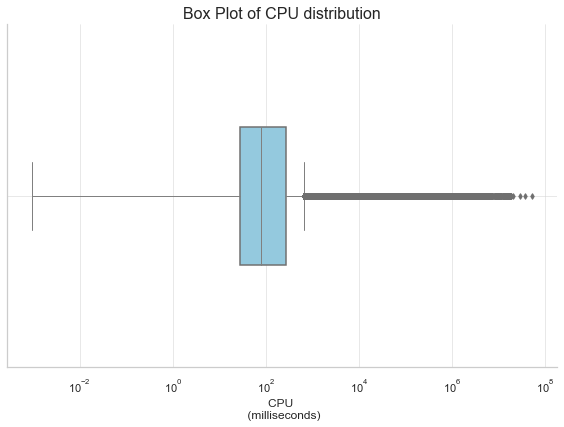

In [4]:
# PLOT CPU

value = google_tasks['CPU']

# Set up seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
sns.boxplot(x=value, ax=ax, color='skyblue', linewidth=1.5, width=0.4, fliersize=4)

# Set the title and labels
ax.set_title('Box Plot of CPU distribution', fontsize=16)
ax.set_xlabel('CPU \n (milliseconds)', fontsize=12)
ax.set_ylabel('', fontsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the whiskers and caps
for line in ax.lines:
    line.set_color('gray')
    line.set_linewidth(1)

# Add a horizontal grid
ax.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
# Show the plot
plt.tight_layout()
plt.xscale('log')
plt.show()

In [5]:
start_time = list(google_tasks["Arrival_Time"])[0]
end_time = list(google_tasks["Arrival_Time"])[-1] + list(google_tasks["CPU"])[-1]/0.1
time_elapsed = end_time - start_time
work_time = sum(google_tasks["CPU"])/0.1/64

In [6]:
work_time/time_elapsed

0.5384247518308163

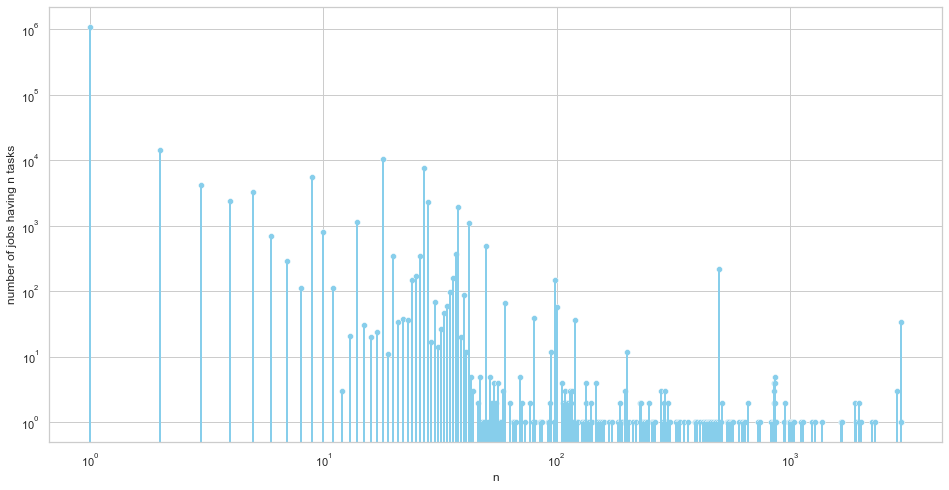

In [21]:
values = google_tasks.groupby('Job_ID').agg({'Task_ID': 'count'})
values["Job_ID"] = values.index
values = values.groupby("Task_ID").agg({"Job_ID":"count"})
values["number_of_tasks"] = values.index
values["number_of_jobs_with_that_number_of_tasks"] = values["Job_ID"]
x  , y = values['number_of_tasks'] , values["number_of_jobs_with_that_number_of_tasks"]
fig, ax = plt.subplots(figsize=(16, 8))  # Adjust the width and height as desired

# Create scatter plot using Seaborn
sns.scatterplot(x=x, y=y, color='skyblue')

line_height = 0.2  # Adjust this value to control the height of the lines


# Create the vertical lines
plt.vlines(x, ymin=0, ymax=y, colors='skyblue', linewidth=2)

# Set labels and title
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('number of jobs having n tasks')


# Display the plot
plt.show()

# BASELINE SCHEDULING AND DISPATCHER

In [118]:
class Server:
    def __init__(self, mu):
        self.task_queue = []
        self.workload_status = 0
        self.mu = mu
        self.dead_time = 0

    def schedule_task(self, task):

        task['Delay'] = self.get_delay(task)
        task['Return_Time'] =  task['Arrival_Time'] + (task['CPU'] / self.mu) + task['Delay']
        self.task_queue.append(task)
        self.workload_status = task['Return_Time']

    def get_delay(self,task):
        if not self.task_queue : return 0
        prev_task = self.task_queue[-1]
        delay = prev_task["Return_Time"] - task["Arrival_Time"]
        if delay <= 0:
            self.dead_time -= delay
            return 0
        return delay

    def get_work_time(self):
        start_time = self.task_queue[0]["Arrival_Time"]
        end_time = self.task_queue[-1]["Return_Time"]
        return end_time-start_time

    def get_utilization_coefficient(self):
        return 1 - self.dead_time/self.get_work_time()

In [117]:
def dispatcher(servers, tasks):
    for task in tqdm(tasks.iterrows(), total=len(tasks)):
        selected_index = np.argmin([server.workload_status for server in servers])
        servers[selected_index].schedule_task(dict(task[1]))

# CUSTOM SCHEDULING AND DISPATCHER


In [120]:
'''
Highest response ratio next
check it out: https://en.wikipedia.org/wiki/Highest_response_ratio_next
'''
class CustomServer:

    def __init__(self, mu):
        self.task_queue = []
        self.historic_task_queue = []
        self.workload_status = 0
        self.mu = mu

    def schedule_task(self, task):

        task["Delay"] = 0
        self.pop_from_queue(task['Arrival_Time'])
        self.task_queue.append(task)
        self.workload_status = task['Arrival_Time'] + sum([task["CPU"]  for task in self.task_queue])/self.mu

    def pop_from_queue(self, time):

        while self.task_queue:
            first_task = self.task_queue[0]
            first_return_time = first_task['Delay'] + first_task['Arrival_Time'] + (first_task['CPU']/self.mu)
            if first_return_time < time:
                first_task['Return_Time'] = first_return_time
                self.historic_task_queue.append(first_task)
                self.task_queue.pop(0)
                for task in self.task_queue:
                    task['Delay'] = first_return_time - task["Arrival_Time"]
                self.update_queue()
            else:
                break
        return

    def update_queue(self):
        self.task_queue = sorted(self.task_queue,key = self.score, reverse=True)

    def score(self,task):
        return 1+task['Delay']/(task['CPU']/self.mu)

    def get_dead_time(self):
        dead_time = 0
        for prev_task, next_task in zip(self.historic_task_queue[:-1], self.historic_task_queue[1:]):
            delay = next_task["Arrival_Time"] - prev_task["Return_Time"]
            if delay > 0:
                dead_time += delay

        return dead_time

    def get_work_time(self):
        start_time = self.historic_task_queue[0]["Arrival_Time"]
        end_time = self.historic_task_queue[-1]["Return_Time"]
        return end_time-start_time

    def get_utilization_coefficient(self):
        return 1 - (self.get_dead_time()/self.get_work_time())

    def get_updates_coefficient(self):
        htq = self.historic_task_queue
        ordered = [htq[i]["Arrival_Time"] <= htq[i+1]["Arrival_Time"] for i in range(len(htq) - 1)]
        return 1-(sum(ordered)/len(ordered))

In [122]:
def custom_dispatcher(servers, tasks,initial_window):

    available_servers = []
    length = []
    message_counter = 0

    for task in tqdm(tasks.iterrows(), total=len(tasks)):

        if not available_servers:
            my_task = dict(task[1])
            servers_status = [server.workload_status for server in servers]
            min_status = min(servers_status)
            alpha = 0.5
            while min_status > my_task["Arrival_Time"] + alpha * initial_window:
                alpha *= 2

            for i,status in enumerate(servers_status):
                if status <  dict(task[1])["Arrival_Time"] + alpha * initial_window:
                    available_servers.append(i)

            length.append(len(available_servers))
            available_servers.sort()
            message_counter += 128 + len(available_servers)


        servers[available_servers[0]].schedule_task(dict(task[1]))
        available_servers.pop(0)

    for server in servers:
        server.pop_from_queue(np.Inf)

    return(length,message_counter/len(tasks))

# SIMULATIONS

In [123]:
# SIMULATION PARAMETERS
N = 64
mu = 0.1

In [126]:
# BASELINE
servers = [Server(mu=mu) for _ in range(N)]
dispatcher(servers, google_tasks)

100%|██████████| 2282872/2282872 [02:22<00:00, 15996.53it/s]


In [127]:
# CUSTOM
custom_servers = [CustomServer(mu=mu) for _ in range(N)]
length,mean_message_counter = custom_dispatcher(custom_servers, google_tasks,10)

100%|██████████| 2282872/2282872 [10:56<00:00, 3476.17it/s] 


In [128]:
np.mean(length)

6.785883080325427

In [129]:
mean_message_counter

19.86293230632291

# Metrics Mining

In [130]:
# MERGE ALL SERVERS TOGETHER
df_total_tasks = pd.DataFrame(functools.reduce(lambda a, b: a+b, [server.task_queue for server in servers]))

custom_df_total_tasks = \
    pd.DataFrame(functools.reduce(lambda a, b: a+b, [server.historic_task_queue for server in custom_servers]))

In [131]:
# GROUP PER JOB AND GET STATISTICS

df_jobs =  df_total_tasks.groupby('Job_ID').agg({'Arrival_Time': 'min', 'Return_Time': 'max', 'CPU': 'sum'})
df_jobs['CPU'] = df_jobs['CPU'] / mu
df_jobs['Job_Time'] = df_jobs['Return_Time'] - df_jobs['Arrival_Time']
df_jobs['SlowDown'] = df_jobs['Job_Time'] / df_jobs['CPU']


custom_df_jobs =  custom_df_total_tasks.groupby('Job_ID').agg({'Arrival_Time': 'min', 'Return_Time': 'max', 'CPU': 'sum'})
custom_df_jobs['CPU'] = custom_df_jobs['CPU'] / mu
custom_df_jobs['Job_Time'] = custom_df_jobs['Return_Time'] - custom_df_jobs['Arrival_Time']
custom_df_jobs['SlowDown'] = custom_df_jobs['Job_Time'] / custom_df_jobs['CPU']


In [156]:
# GET UTILIZATION COEFFICIENTS
utilization_coefficients = [server.get_utilization_coefficient() for server in servers]
custom_utilization_coefficients = [server.get_utilization_coefficient() for server in custom_servers]

In [133]:
# GET UPDATES COEFFICIENTS FOR CUSTOM SETTING
updates_coefficients = [server.get_updates_coefficient() for server in custom_servers]

# METRICS PLOTS

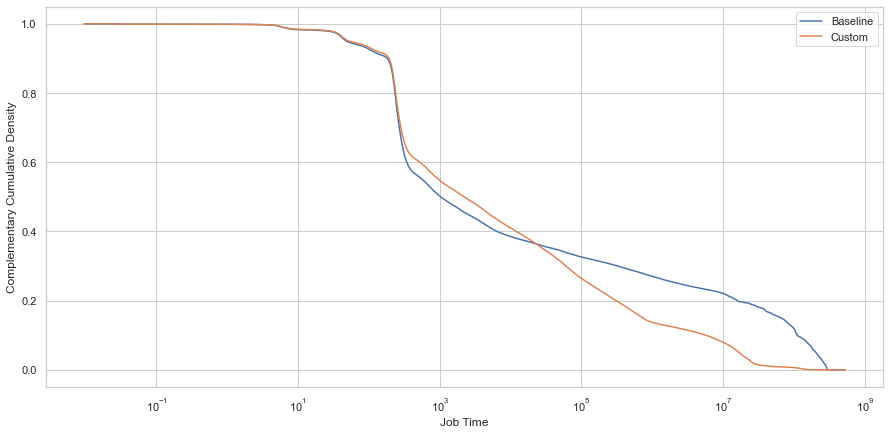

In [160]:
# JOB TIME
custom_df_jobs = custom_df_jobs.sort_values(by='Job_Time')
df_jobs = df_jobs.sort_values(by='Job_Time')

plt.figure(figsize=(15,7))

plt.plot(df_jobs['Job_Time'], 1- (np.arange(1, len(df_jobs)+1) / len(df_jobs['Job_Time'])))
plt.plot(custom_df_jobs['Job_Time'], 1-  (np.arange(1, len(custom_df_jobs)+1) / len(custom_df_jobs['Job_Time'])))

plt.xlabel("Job Time")
plt.ylabel("Complementary Cumulative Density")
plt.xscale('log')
plt.legend(["Baseline","Custom"]);


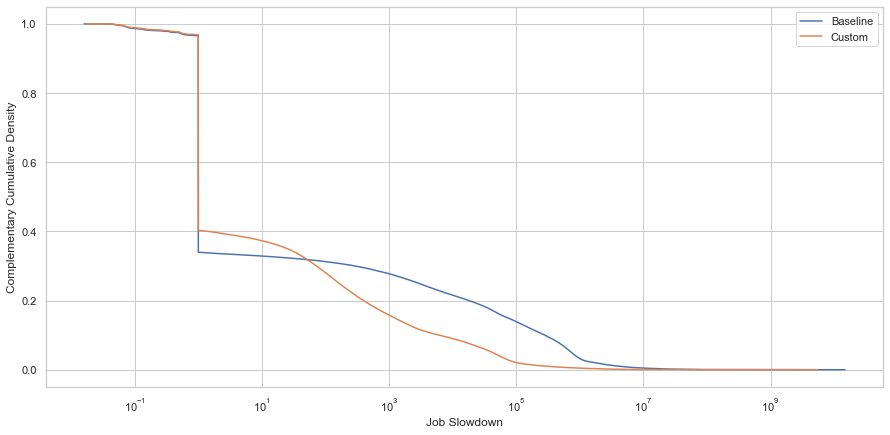

In [161]:
# JOB SLOWDOWN
custom_df_jobs = custom_df_jobs.sort_values(by='SlowDown')
df_jobs = df_jobs.sort_values(by='SlowDown')

plt.figure(figsize=(15,7))

plt.plot(df_jobs['SlowDown'], 1 - (np.arange(1, len(df_jobs)+1) / len(df_jobs['SlowDown'])))
plt.plot(custom_df_jobs['SlowDown'], 1 - (np.arange(1, len(custom_df_jobs)+1) / len(custom_df_jobs['SlowDown'])))

plt.xlabel("Job Slowdown")
plt.ylabel("Complementary Cumulative Density")
plt.xscale('log')

plt.legend(["Baseline","Custom"]);

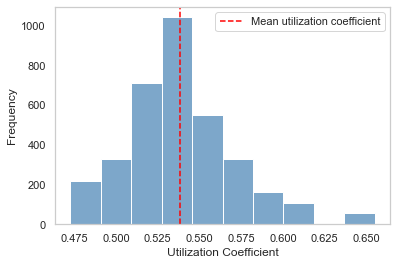

0.5384731178154387

In [157]:
# BASELINE UTILIZATION COEFFICIENTS HISTOGRAM
sns.histplot(utilization_coefficients, bins='auto', color='steelblue', alpha=0.7, stat='frequency')
plt.axvline(x=np.mean(utilization_coefficients),color="Red" , linestyle = "--" )
plt.legend(["Mean utilization coefficient"])
plt.xlabel('Utilization Coefficient')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()
np.mean(utilization_coefficients)

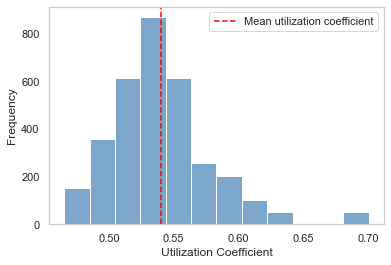

0.5399556476022129

In [175]:
# CUSTOM UTILIZATION COEFFICIENTS HISTOGRAM
sns.histplot(custom_utilization_coefficients, bins='auto', color='steelblue', alpha=0.7, stat='frequency')
plt.axvline(x=np.mean(custom_utilization_coefficients),color="Red" , linestyle = "--" )
plt.legend(["Mean utilization coefficient"])
plt.xlabel('Utilization Coefficient')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()
np.mean(custom_utilization_coefficients)

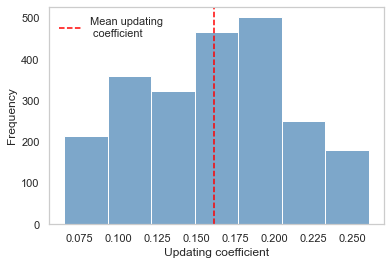

0.16132431709874936

In [176]:
# UPDATING COEFFICIENTS HISTOGRAM
sns.histplot(updates_coefficients, bins='auto', color='steelblue', alpha=0.7, stat='frequency')
plt.axvline(x=np.mean(updates_coefficients),color="Red" , linestyle = "--" )
plt.legend(["Mean updating \n coefficient"]  , frameon=False)
plt.xlabel('Updating coefficient')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()
np.mean(updates_coefficients)

In [163]:
# Baseline  load L
'''
Since the baseline dispatcher must ask to every server if they can take the task and each of them responds
we have N * 2 messages + 1 another message from the dispatcher assigning the job
'''
print(2*N+1)

129
